In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from pathlib import Path
import sys
sys.path.append('../../')
from utils.metrics import calculate_anomaly_metrics, format_results
from utils.plots import standard_plots

In [36]:
# 1. LOAD DATA
train = pd.read_csv('../data/train.csv')

feature_cols = [
    'setting_1', 'setting_2', 'setting_3',
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 
    'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 
    'sensor_14', 'sensor_15', 'sensor_17', 'sensor_21'
]


In [37]:
X_train_all = train[feature_cols].values

model = IsolationForest(
    contamination=0.08,
    random_state=42,
    n_estimators=100
)
model.fit(X_train_all)

,n_estimators,100
,max_samples,'auto'
,contamination,0.08
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [38]:
# 4. PREDICT
# Then predict on train and test
predictions = model.predict(X_train_all)
train['is_anomaly'] = (predictions == -1).astype(int)
train['anomaly_score'] = -model.decision_function(X_train_all)

In [39]:
# 5. METRICS
metrics = calculate_anomaly_metrics(train)
metrics['method'] = 'Isolation Forest'
metrics['dataset'] = 'FD001'
format_results(metrics)


📊 Isolation Forest - FD001
Cobertura: 100.0% (100/100 unidades)
RUL promedio 1ª detección: 75.3 ciclos
Detección al 65.4% del ciclo
Detecciones tempranas (RUL>50): 28
Falsos positivos (RUL>150): 27.0%
% anomalías totales: 8.0%


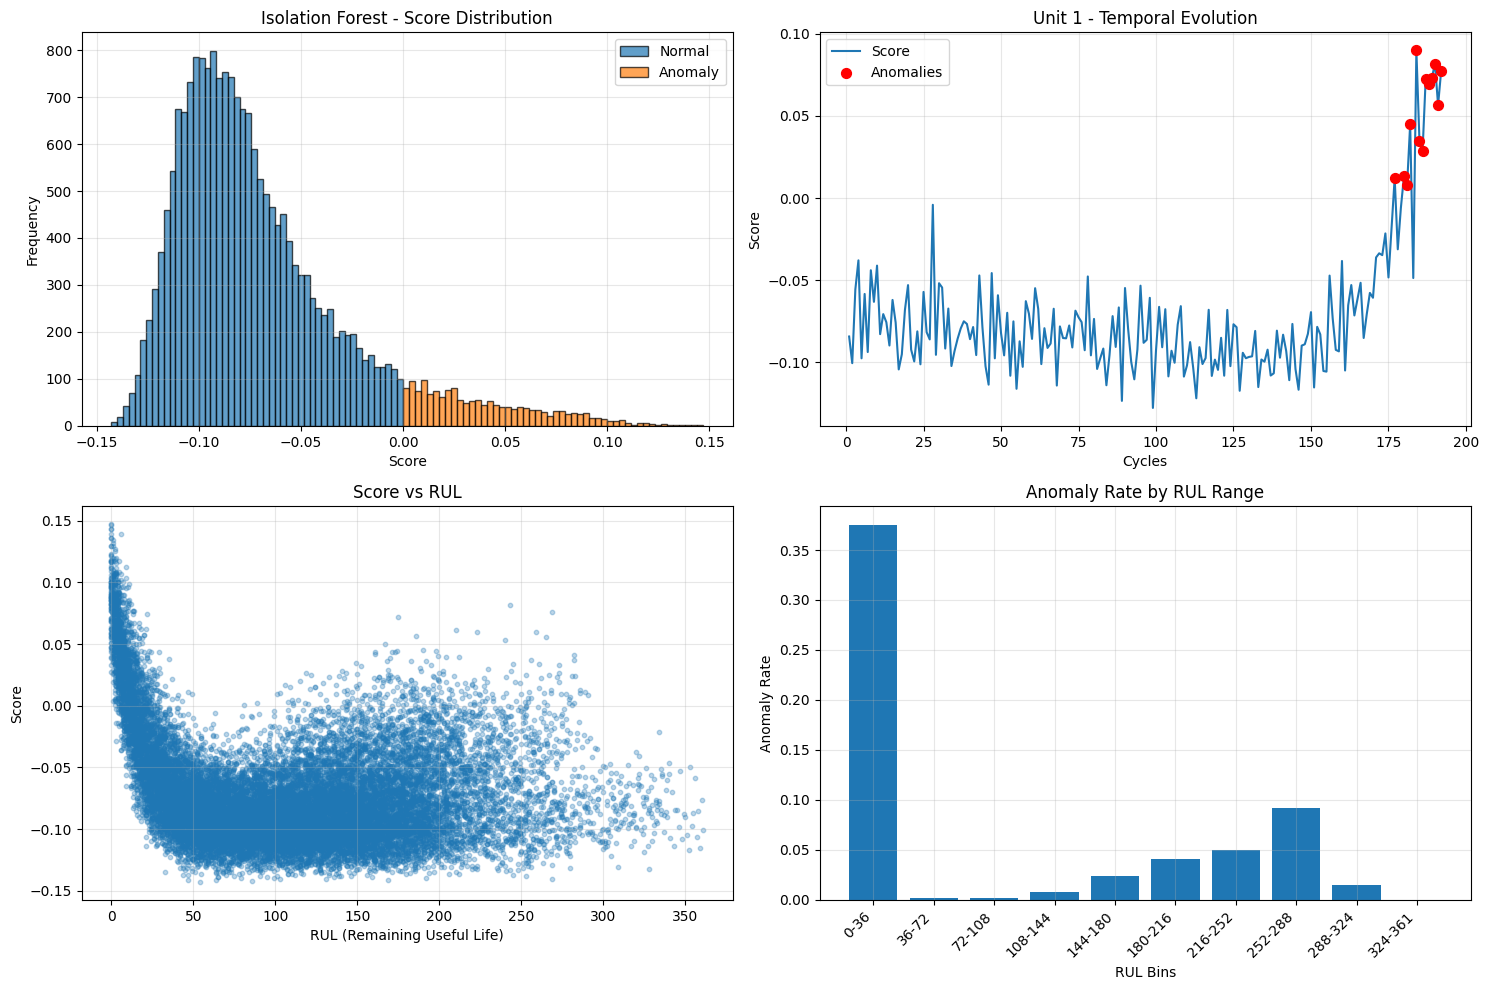

In [40]:
# 6. PLOTS
standard_plots(
    train=train,
    score_col='anomaly_score',
    method_name='Isolation Forest',
    output_path='./outputs'
)

In [41]:
# 7. SAVE
output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

train[['unit_id', 'time_cycles', 'RUL', 'anomaly_score', 'is_anomaly']].to_csv(
    output_dir / 'isolation_forest_anomalies.csv', index=False
)

pd.DataFrame([metrics]).to_csv(
    output_dir / 'isolation_forest_metrics.csv', index=False
)

print("✅ Saved to ./outputs/")

✅ Saved to ./outputs/


In [42]:
print(rul_test.head())
print(rul_test.columns)

   RUL  unit_id
0  112        1
1   98        2
2   69        3
3   82        4
4   91        5
Index(['RUL', 'unit_id'], dtype='object')


📊 Isolation Forest - FD001-TEST
Cobertura: 39.0% (39/100 unidades)
RUL promedio 1ª detección: 161.3 ciclos
Detección al 33.0% del ciclo
Detecciones tempranas (RUL>50): 29
Falsos positivos (RUL>150): 69.2%
% anomalías totales: 2.2%


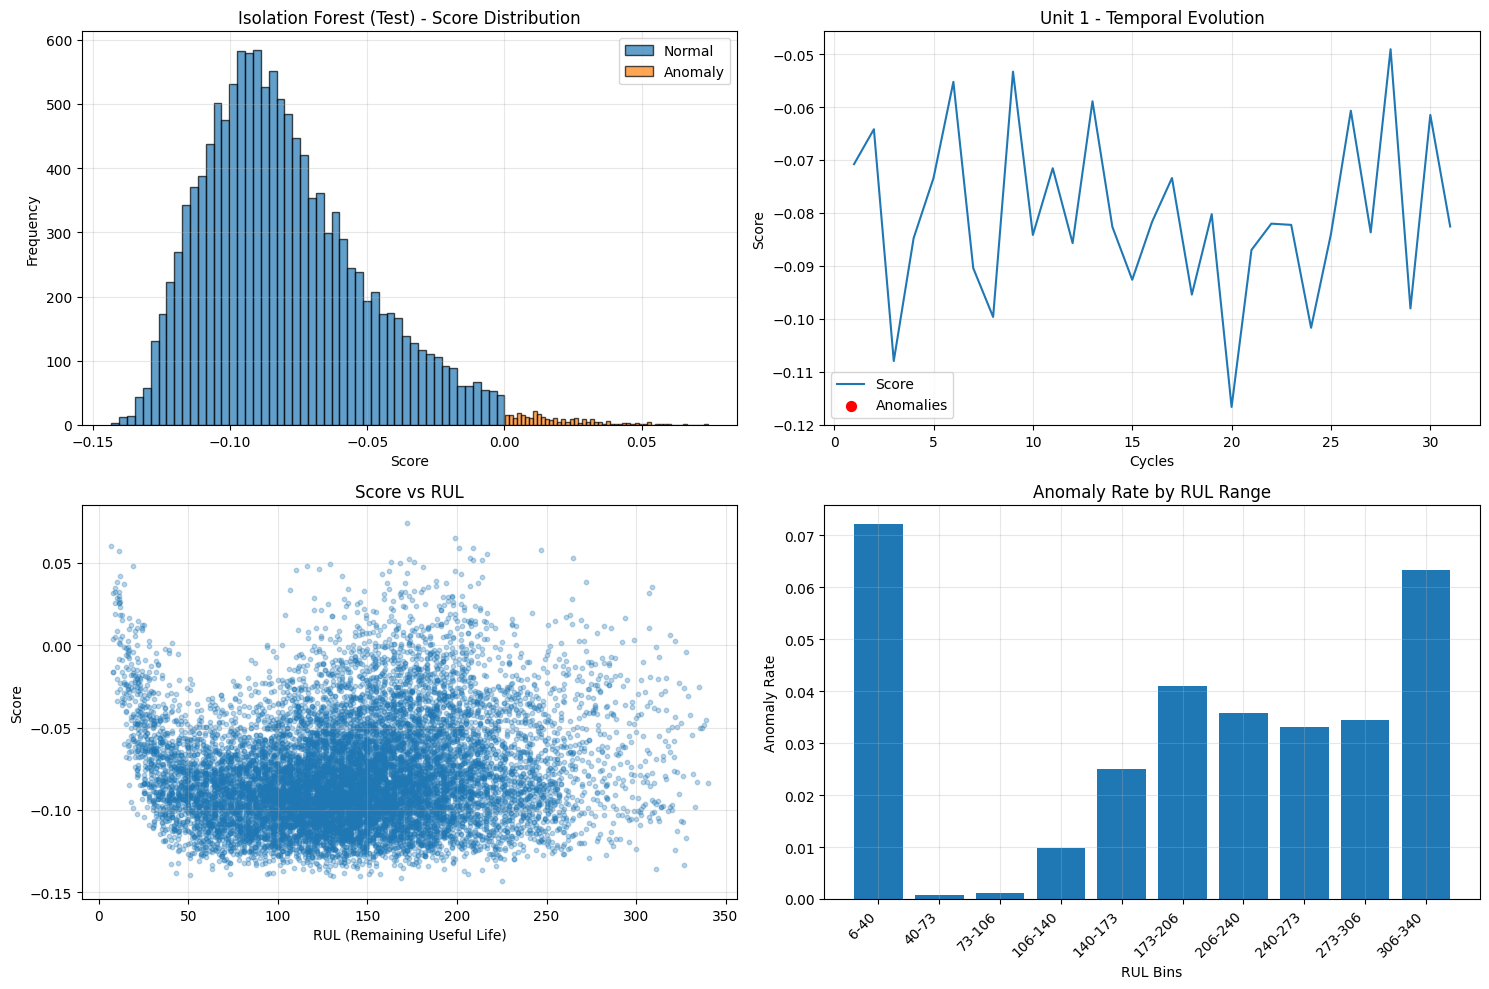

In [43]:
# TEST EVALUATION
test = pd.read_csv('../data/test.csv')
rul_test = pd.read_csv('../data/rul.csv')

# Predict
X_test = test[feature_cols].values
predictions_test = model.predict(X_test)
test['is_anomaly'] = (predictions_test == -1).astype(int)
test['anomaly_score'] = -model.decision_function(X_test)

# Calculate RUL
rul_test['unit_id'] = range(1, len(rul_test) + 1)
test = test.sort_values(['unit_id', 'time_cycles'])
test['max_cycle'] = test.groupby('unit_id')['time_cycles'].transform('max')
test = test.merge(rul_test, on='unit_id', how='left')  # Sin suffixes
test['RUL'] = test['RUL'] + (test['max_cycle'] - test['time_cycles'])

# Metrics & Plots
metrics_test = calculate_anomaly_metrics(test)
metrics_test['method'] = 'Isolation Forest'
metrics_test['dataset'] = 'FD001-TEST'
format_results(metrics_test)

standard_plots(test, 'anomaly_score', 'Isolation Forest (Test)', './outputs')

# Save
test[['unit_id', 'time_cycles', 'RUL', 'anomaly_score', 'is_anomaly']].to_csv(
    output_dir / 'isolation_forest_test_anomalies.csv', index=False
)
pd.DataFrame([metrics_test]).to_csv(
    output_dir / 'isolation_forest_test_metrics.csv', index=False
)

In [44]:
print(metrics_test)

{'method': 'Isolation Forest', 'dataset': 'FD001-TEST', 'total_units': 100, 'units_detected': 39, 'detection_rate': 39.0, 'avg_first_detection_rul': np.float64(161.33333333333334), 'avg_detection_cycle_pct': np.float64(32.97316605588333), 'early_detections': 29, 'false_positive_rate': 69.23076923076923, 'anomaly_percentage': np.float64(2.206780696395846)}
